# Handling Missing Time Series Data.
## As expected in any data analysis task, proper cleaning and preprocessing of the data is required.

### Upsampling and Downsampling
- Missing data is a common occurrence that happens during data collection, due to **faulty entries** or **outright omission**. Time series data is no exception to this problem.
* methods used to handle missing data in time series
     - Imputation,
     - interpolation and
     - deletion of missing data points

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')

In [3]:
df['Month'] = pd.to_datetime(df['Month']) # convert column to dateime
df.set_index('Month', inplace= True)

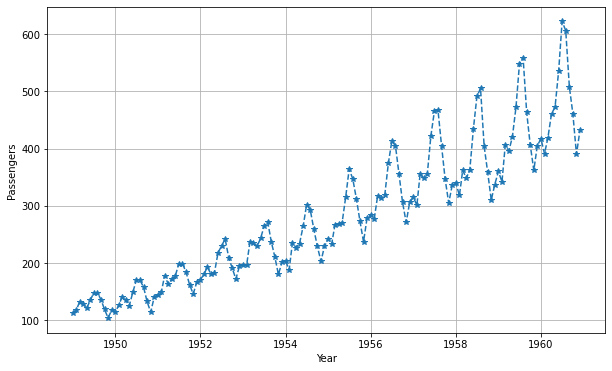

In [4]:
plt.figure(figsize= (10, 6))
plt.plot(df.index, df.Passengers, '--', marker= '*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers');

In [5]:
# Check for missing values
df.isnull().values.any() # there are no missing

False

In [6]:
# make a copy of our dataset and delete some values at random
df_copy = df.copy()
rows = df_copy.sample(frac= 0.1, random_state= 0)
rows['Passengers'] =  np.nan
df_copy.loc[rows.index, 'Passengers'] = rows['Passengers']
df_copy.isnull().sum()

Passengers    14
dtype: int64

In [7]:
# Filling missing data by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method='ffill')
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

In [8]:
# Filling missing data by imputation - Forward fill
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

In [9]:
# Filling missing data by interpolation Forward
df_copy_LIF = df_copy.interpolate(method='linear', limit_direction='forward')
df_copy_LIF.isnull().sum()

Passengers    0
dtype: int64

In [10]:
# Filling missing data by interpolation Backward
df_copy_LIB = df_copy.interpolate(method='linear', limit_direction='backward')
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

In [11]:
# Downsample to quarterly data points
df_quarterly = df.resample('3M').mean()
df_quarterly.head()

,Passengers
Month,
1949-01-31,112.000000
1949-04-30,126.333333
1949-07-31,134.666667
1949-10-31,134.333333
1950-01-31,112.333333


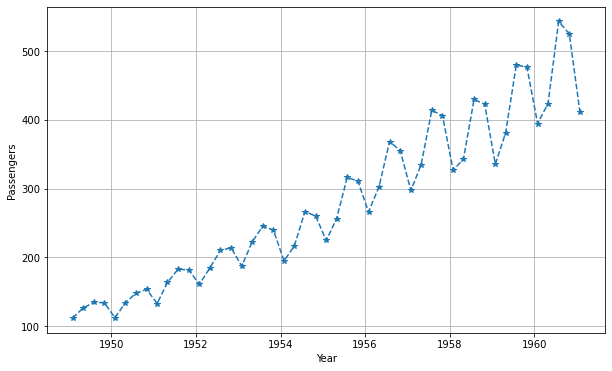

In [12]:
plt.figure(figsize= (10, 6))
plt.plot(df_quarterly.index, df_quarterly.Passengers, '--', marker= '*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers');

In [13]:
# Upsample to daily data points
df_daily = df.resample('D').mean()
df_daily.head()

,Passengers
Month,
1949-01-01,112.0
1949-01-02,NaN
1949-01-03,NaN
1949-01-04,NaN
1949-01-05,NaN


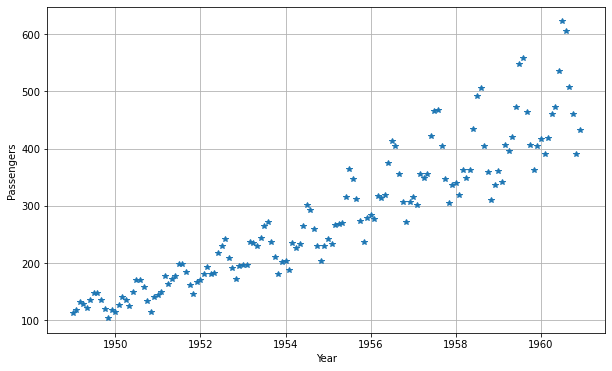

In [14]:
plt.figure(figsize= (10, 6))
plt.plot(df_daily.index, df_daily.Passengers, '--', marker= '*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers');

## Moving average smoothing

In [15]:
df_movAvg = df.copy()
movAvg = df_movAvg['Passengers'].rolling(12).mean()

In [16]:
movAvg.head(20)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01    126.666667
1950-01-01    126.916667
1950-02-01    127.583333
1950-03-01    128.333333
1950-04-01    128.833333
1950-05-01    129.166667
1950-06-01    130.333333
1950-07-01    132.166667
1950-08-01    134.000000
Name: Passengers, dtype: float64

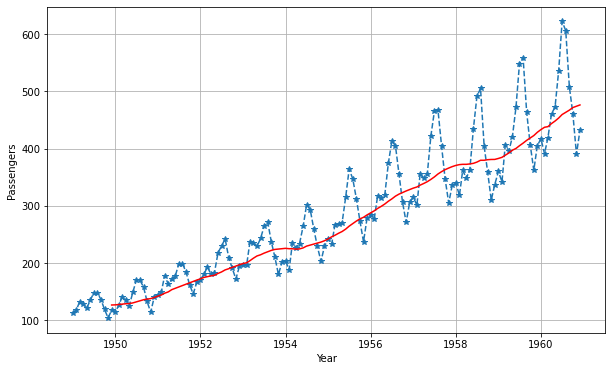

In [17]:
plt.figure(figsize= (10, 6))
plt.plot(df_movAvg.index, df_movAvg.Passengers, '--', marker= '*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers');
plt.plot(df_movAvg.rolling(12).mean(), color= 'red');

## Exploratory data analysis

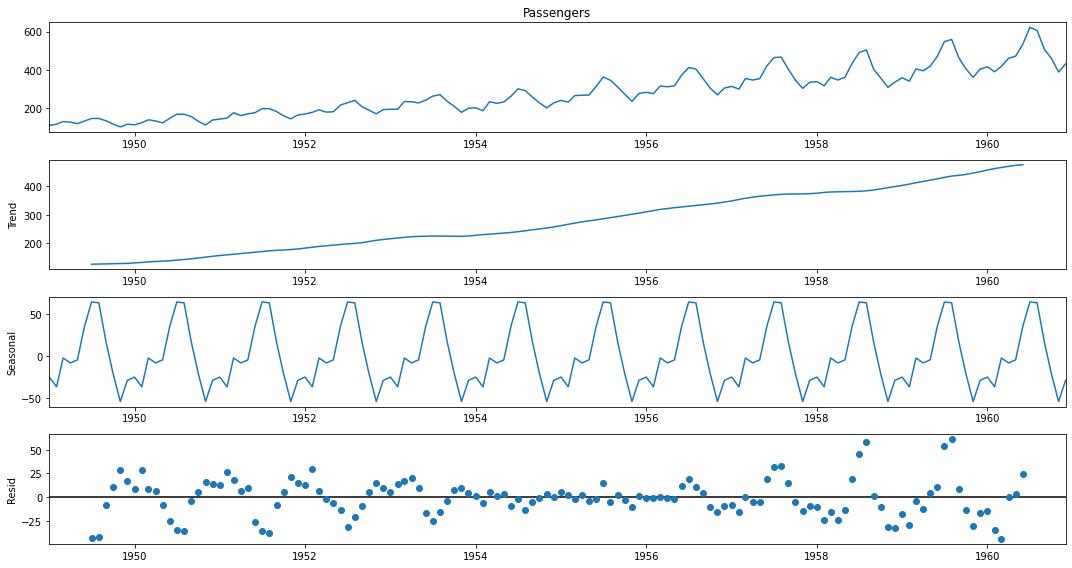

In [18]:
import statsmodels.api as sts
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

decompose_series = sts.tsa.seasonal_decompose(df['Passengers'], model= 'additive')
decompose_series.plot()
plt.show()

The **decomposed** time series show an obvious increasing trend and seasonality variations. 
Recall that we have initially plotted the moving average on the last 12 months which showed that it varies with time. 
This suggests that the data is **not stationary**. 

In [19]:
# Perform an ADF test to confirm this speculation
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Passengers'])

In [20]:
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No of observationused: {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'  {k}: {v}')

ADF Statistic: 0.8153688792060423
p-value: 0.9918802434376409
No. of lags used: 13
No of observationused: 130
Critical Values:
  1%: -3.4816817173418295
  5%: -2.8840418343195267
  10%: -2.578770059171598


From the results obtained, the p-value is greater than the critical value at a 5% 
significance level and, the ADF statistic is greater that any of the critical values obtain. **This confirms** that the series is indeed *non-stationary*.
- Convert time series to stationary by removing trend and seasonality

In [21]:
#Transformation and Differencing
df_log = np.log(df)
df_diff = df_log.diff(periods= 1)

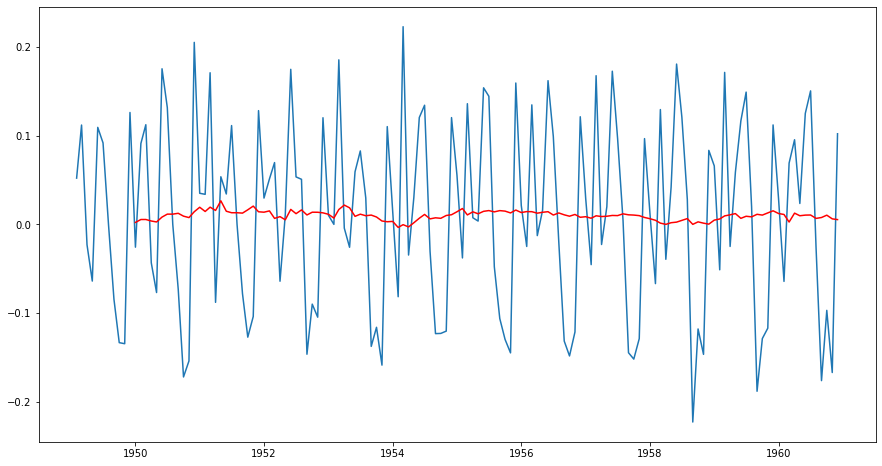

In [22]:
plt.plot(df_diff.index, df_diff.Passengers, '-')
plt.plot(df_diff.rolling(12).mean(), color= 'red');

In [23]:
df_diff = df_diff.fillna(method='bfill')

# Time Series Forecasting Using Stochastic Models

In [24]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

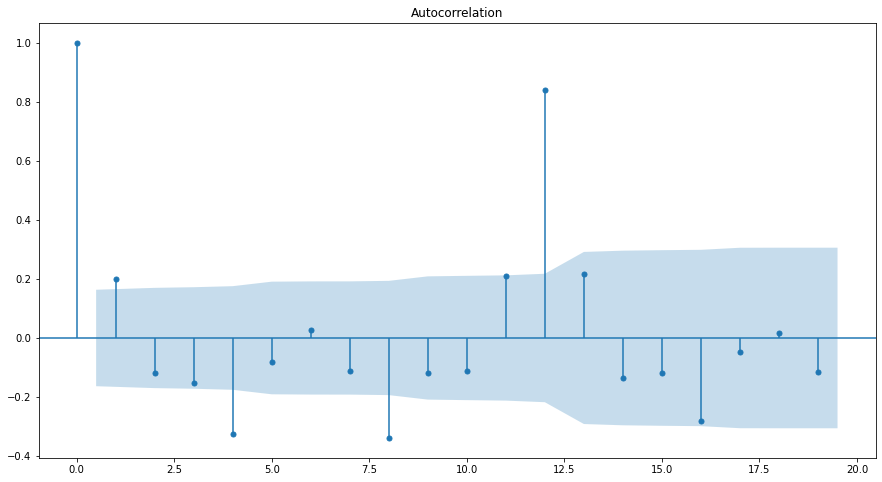

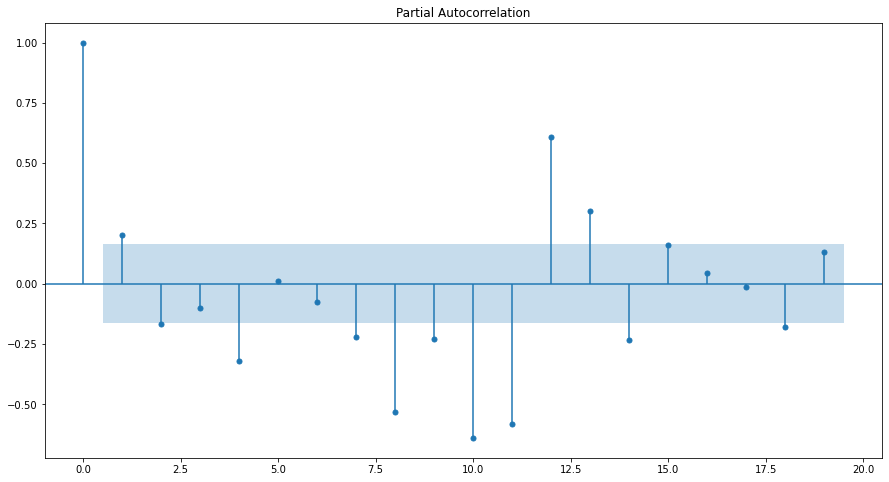

In [25]:
# ACF 
plot_acf(df_diff, lags= range(0, 20))
plt.show();
# PACF 
plot_pacf(df_diff, lags=  range(0, 20))
plt.show()

C:\Users\JK\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\JK\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be 

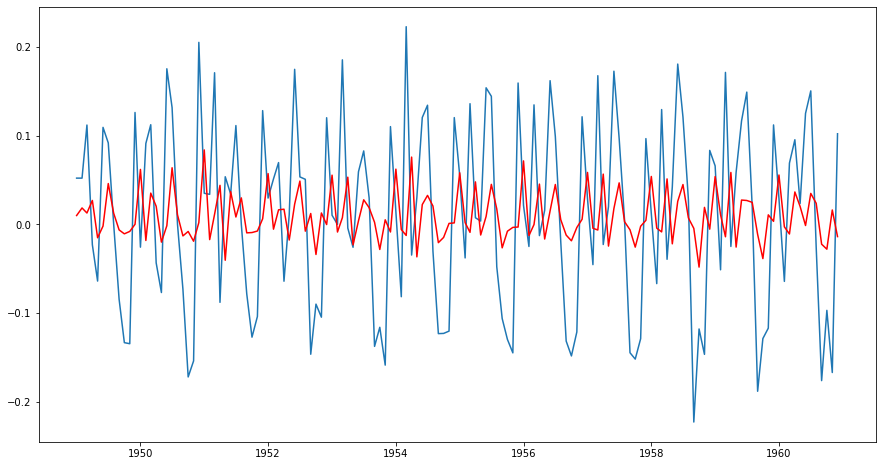

In [26]:
# AR, MA and ARIMA

from statsmodels.tsa.arima_model import ARIMA

# AR (p, d, q)
AR_model = ARIMA(df_diff, order= (2, 0, 0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color= 'red');

C:\Users\JK\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


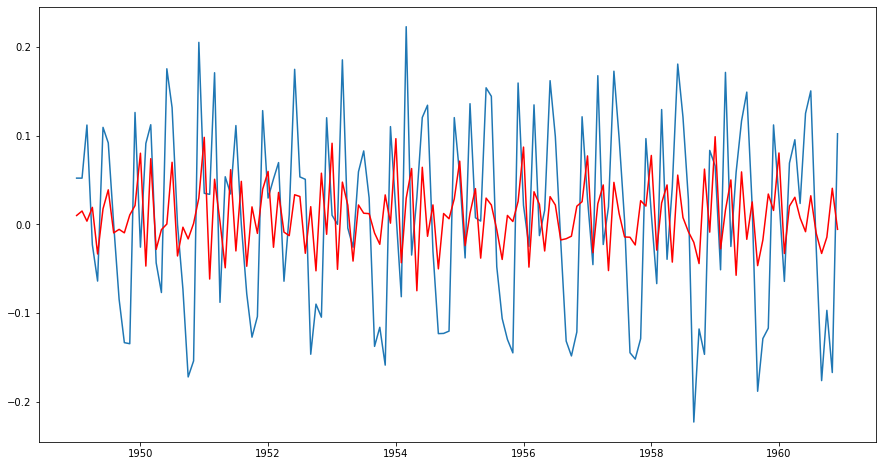

In [27]:
# MA (p, d, q)
MA_model = ARIMA(df_diff, order= (0, 0, 2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color= 'red');

C:\Users\JK\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\JK\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be 

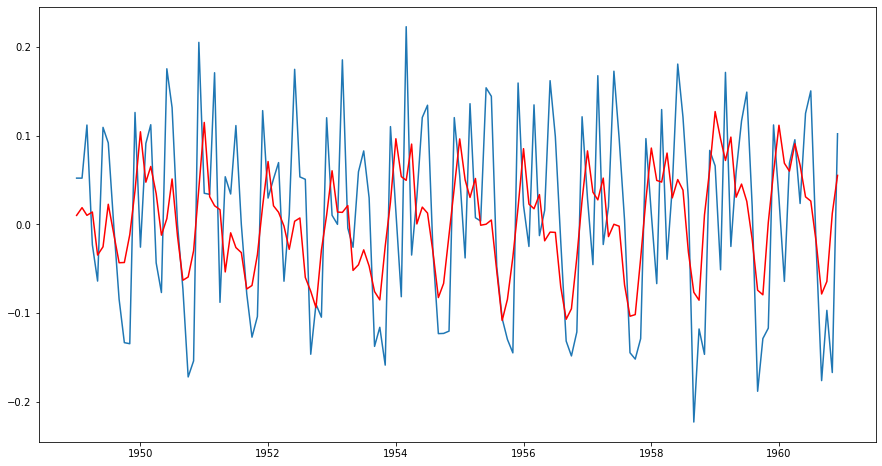

In [28]:
# ARIMA (p, d, q)
ARIMA_model = ARIMA(df_diff, order= (2, 0, 1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color= 'red');

# Time Series at Scale

In [35]:
from fbprophet import Prophet

df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
df['Month'] = pd.to_datetime(df['Month'])

df= df.rename(columns= {'Month': 'ds', 'Passengers': 'y'})
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [36]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


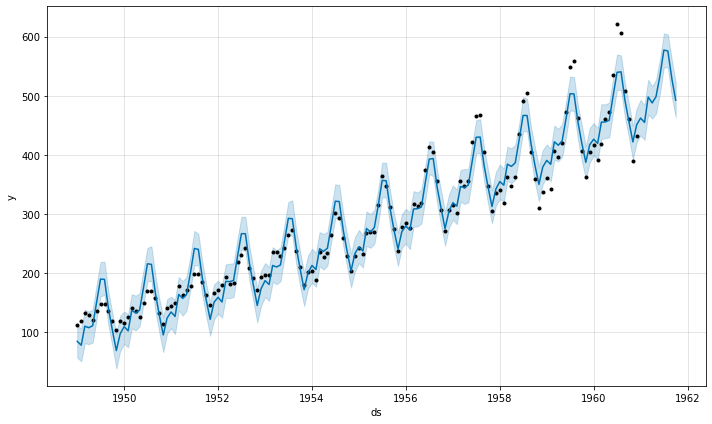

In [38]:
# Predict for the next 10 mohths
future = model.make_future_dataframe(periods= 10, freq= 'M')
forecast = model.predict(future)
forecast.head()

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]
# yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries

model.plot(forecast)
plt.show()